In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input/crosssellprediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input/crosssellprediction/train.csv
../input/crosssellprediction/test.csv
../input/crosssellprediction/sample_submission_iA3afxn.csv


# **Problem Statement**

Your client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

# Data Description

* id -	Unique ID for the customer
* Gender -	Gender of the customer
* Age - Age of the customer
* Driving_License -	0 : Customer does not have DL, 1 : Customer already has DL
* Region_Code - Unique code for the region of the customer
* Previously_Insured -	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* Vehicle_Age -	Age of the Vehicle 
* Vehicle_Damage - 1 : Customer got his/her vehicle damaged in the past, 0 : Customer didn't get his/her vehicle damaged in the past.
* Annual_Premium -	The amount customer needs to pay as premium in the year
* Policy_Sales_Channel	Anonymised Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* Vintage -	Number of Days, Customer has been associated with the company
* Response - 1 :  Customer is interested, 0 : Customer is not interested

* We can see that variables 1 to 11 can be used for modelling.
* Variable 'id' is Identifier column. It has a unique value for every sample in the dataset and cannot be used for modelling.
* Variable 'Response' is Target/y column. It has binary values and we need to learn to predict this variable given our above 11 variables as features.

# Hypothesis Generation

Are old customers more likely to subscribe to Vehicle Insurance compared to young customers ?

Are Male customers more interseted in opting for the to Vehicle Insurance compared to female customers ?

Customers holding driving license are likely to entertain the request for Vehicle Insurance or not?

Does the region the customer belongs to tell us anything about their chances of subscribing ? 

Customer with previous insurance live are interested in opting?

Are the customers with less age of vehicle is not more interested in subscribing?

Customer with damaged vehicles will opt or not?

Does the channel(email, Phone) via which the customer getting contacted have any impact on opting?

Does the number of days the customers have associated with the insurance company and their response to interest in vehicle insurance are correlated?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from xgboost import XGBClassifier,XGBRFClassifier
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,StackingClassifier


from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# EDA

* We have been provided with three files

In [3]:
#reading sample sub file, train and test file
ss = pd.read_csv('../input/crosssellprediction/sample_submission_iA3afxn.csv')
train = pd.read_csv('../input/crosssellprediction/train.csv')
test = pd.read_csv('../input/crosssellprediction/test.csv')




In [4]:
def class_distribution(df, target_col):
  '''
  Function to view distribution of target class
  '''
  class_dist = df[target_col].value_counts().to_dict()
  for i in class_dist.keys():
    percent = (class_dist[i]/train.shape[0])*100
    print(f'Number of records in class {i}: '+str(round(percent,2))+'% values:' +  str(class_dist[i]) )


def miss_data(df):
  '''
  Missing data details
  '''
  x = ['column_name','missing_data', 'missing_in_percentage']
  missing_data = pd.DataFrame(columns=x)
  columns = df.columns
  for col in columns:
      icolumn_name = col
      imissing_data = df[col].isnull().sum()
      imissing_in_percentage = (df[col].isnull().sum()/df[col].shape[0])*100

      missing_data.loc[len(missing_data)] = [icolumn_name, imissing_data, imissing_in_percentage]
  print(missing_data)

def evaluate_model(y_true, y_pred):
  '''
  Validating the prediction values
  '''
  print('CLASSIFICATION REPORT')
  print('***************************')
  print(classification_report(y_true,y_pred))
  print('CONFUSION MATRIX')
  print('****************************')
  cm = confusion_matrix(y_true, y_pred)
  cm_df = pd.DataFrame(cm.T, index=[0,1], columns=[0,1])
  cm_df.index.name = 'Predicted'
  cm_df.columns.name = 'True'
  print(cm_df)
  print('F1-Score')
  print('***************************')
  print( f1_score(y_true, y_pred))
  print('ROC_AUC')
  print('***************************')
  print(roc_auc_score(y_true,y_pred))

Printing the shape of train and test file

In [5]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')


Train contains 381109 samples and 12 variables

Test contains 127037 samples and 11 variables


As mentioned earlier we have 11 features as inputs and one as target

# Exploring the train and test dataset more

In [6]:
train.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1


In [7]:

test.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199


As metioned earlier the ID column is an unqiue column so cannot be used for modeling, lets create a variable and use the name of the variable further

In [8]:
ID_COL, TARGET_COL = 'id', 'Response'
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

In [9]:
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


The dataset contains 10 features


# DISTRIBUTION OF TARGET FEATURE

'Number of People who did subscribe for a VEHICLE INSURANCE and the number of people who did not'

In [10]:
class_distribution(train,'Response')

Number of records in class 0: 87.74% values:334399
Number of records in class 1: 12.26% values:46710


visualizing the same target distribution in a countplot.

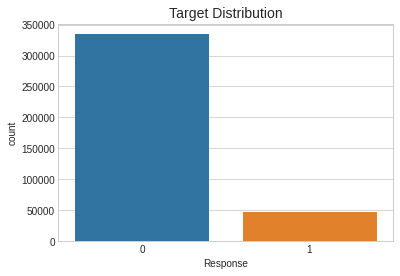

In [11]:
PLOT = sns.countplot(train[TARGET_COL])
PLOT = plt.title("Target Distribution", fontsize=14)

The above distribution shows 88% of customers are not interested in vehicle insurance and 12% of customers are interested to take vehicle insurance and also it shows that that the target variable is highly imbalanced. Biased towards one class.

# Variable Datatypes

pandas info() method on dataframe allows to do that. For each variable we can see the number of non-null values along with their datatypes.

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  float64
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  float64
 10  Vintage               127037 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 10.7+ MB


Looks like we have a mixture of datatypes, few of those variables are object datatypes. Object datatypes are used to store strings along with other non-numeric data. This is obvious since we encountered a few of strings when we had a look at the dataset.

Machine Learning Models understand only numbers so we will have to later convert these strings to numbers

# Null Values
Although the info() function did tell us about non-null values ideally we will have a look at the percentage of null values in each variable

In [14]:
miss_data(train)

             column_name missing_data  missing_in_percentage
0                     id            0                    0.0
1                 Gender            0                    0.0
2                    Age            0                    0.0
3        Driving_License            0                    0.0
4            Region_Code            0                    0.0
5     Previously_Insured            0                    0.0
6            Vehicle_Age            0                    0.0
7         Vehicle_Damage            0                    0.0
8         Annual_Premium            0                    0.0
9   Policy_Sales_Channel            0                    0.0
10               Vintage            0                    0.0
11              Response            0                    0.0


Perfect !!! we dont have any NULL values in our dataset hence we dont have the process of handling missing values here 

# Unique values in each variable

In [15]:

print('Number of unique elements in each column')
print('******************************************')
for i in train.columns:
  uniq = train[i].nunique()
  print(f'{i}: {uniq}')

Number of unique elements in each column
******************************************
id: 381109
Gender: 2
Age: 66
Driving_License: 2
Region_Code: 53
Previously_Insured: 2
Vehicle_Age: 3
Vehicle_Damage: 2
Annual_Premium: 48838
Policy_Sales_Channel: 155
Vintage: 290
Response: 2


In [16]:
CATEGORICAL = ['Gender','Driving_License','Previously_Insured',\
               'Vehicle_Age','Vehicle_Damage',\
               'Policy_Sales_Channel','Region_Code']

In [17]:
print('Unique values in each column')
print('******************************************')
for i in CATEGORICAL:
  uniq = train[i].unique()
  print(f'{i}: {uniq}')

Unique values in each column
******************************************
Gender: ['Male' 'Female']
Driving_License: [1 0]
Previously_Insured: [0 1]
Vehicle_Age: ['> 2 Years' '1-2 Year' '< 1 Year']
Vehicle_Damage: ['Yes' 'No']
Policy_Sales_Channel: [ 26. 152. 160. 124.  14.  13.  30. 156. 163. 157. 122.  19.  22.  15.
 154.  16.  52. 155.  11. 151. 125.  25.  61.   1.  86.  31. 150.  23.
  60.  21. 121.   3. 139.  12.  29.  55.   7.  47. 127. 153.  78. 158.
  89.  32.   8.  10. 120.  65.   4.  42.  83. 136.  24.  18.  56.  48.
 106.  54.  93. 116.  91.  45.   9. 145. 147.  44. 109.  37. 140. 107.
 128. 131. 114. 118. 159. 119. 105. 135.  62. 138. 129.  88.  92. 111.
 113.  73.  36.  28.  35.  59.  53. 148. 133. 108.  64.  39.  94. 132.
  46.  81. 103.  90.  51.  27. 146.  63.  96.  40.  66. 100.  95. 123.
  98.  75.  69. 130. 134.  49.  97.  38.  17. 110.  80.  71. 117.  58.
  20.  76. 104.  87.  84. 137. 126.  68.  67. 101. 115.  57.  82.  79.
 112.  99.  70.   2.  34.  33.  74. 102. 14

The numerical features 'id', 'Age','Region_Code', 'Annual_Premium','Policy_Sales_Channel', 'Vintage' contain a lot of unique values which is quite obvious.

There are two types of features that we have:

1. Categorical
2. Numerical.

Also our target is Binary

For each feature type we will have to perform two types of analysis:

Univariate: Analyze 1 feature at a time

Bivariate: Analyze the relationship of that feature with target variable, i.e.'Response'

By doing these analysis we can come up with the conclusion for our hypothesis

In [18]:
train.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

# Segregating Categorical & Numerical Variables

In [19]:
cat_cols = ['Gender',
 'Driving_License',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage']

In [20]:
#num_cols = train.select_dtypes(include = np.number).columns
num_cols =  [c for c in features if c not in cat_cols]
#num_cols = ['Region_Code']  # 'Age']', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
num_cols

['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

## Categorical Features¶
### Univariate Analysis - Pie Charts.
Pie Charts can be useful in seeing the proportion of samples, that fall into each category of a categorical variable. For each of the categorical variables we will make a pie chart

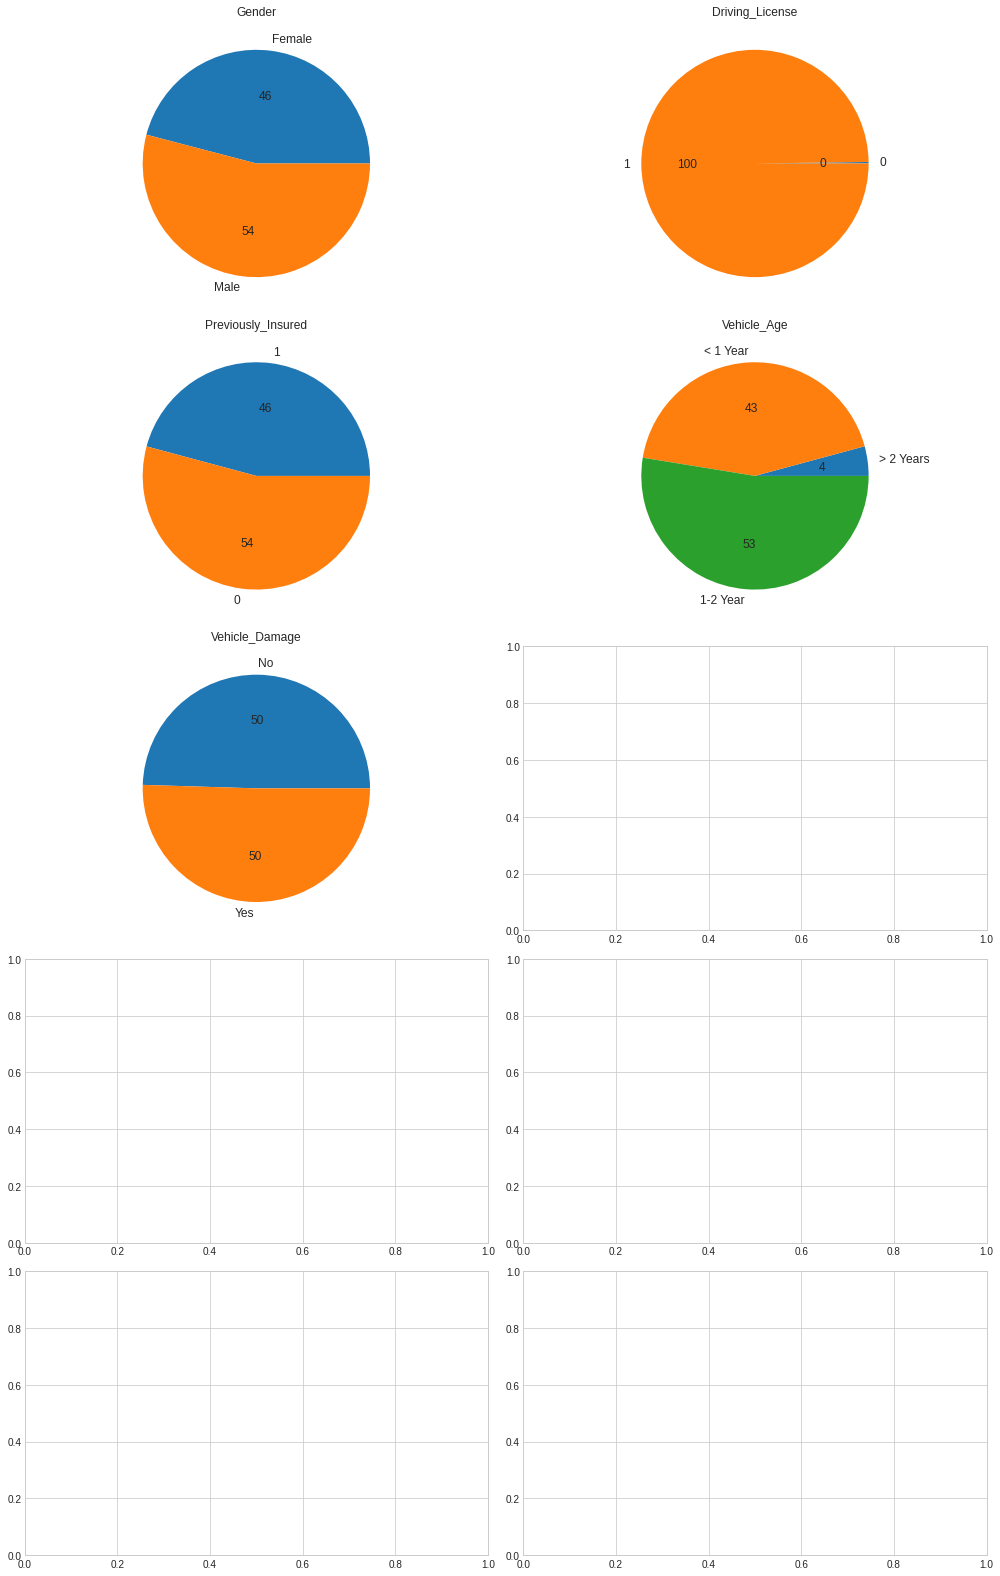

In [21]:
fig, axes = plt.subplots(5, 2, figsize=(14, 22))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=12)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

From the Above chart we can infer that the most of the features are balanced except Driving license.
Let us look at the counts of each of the categories using countplots

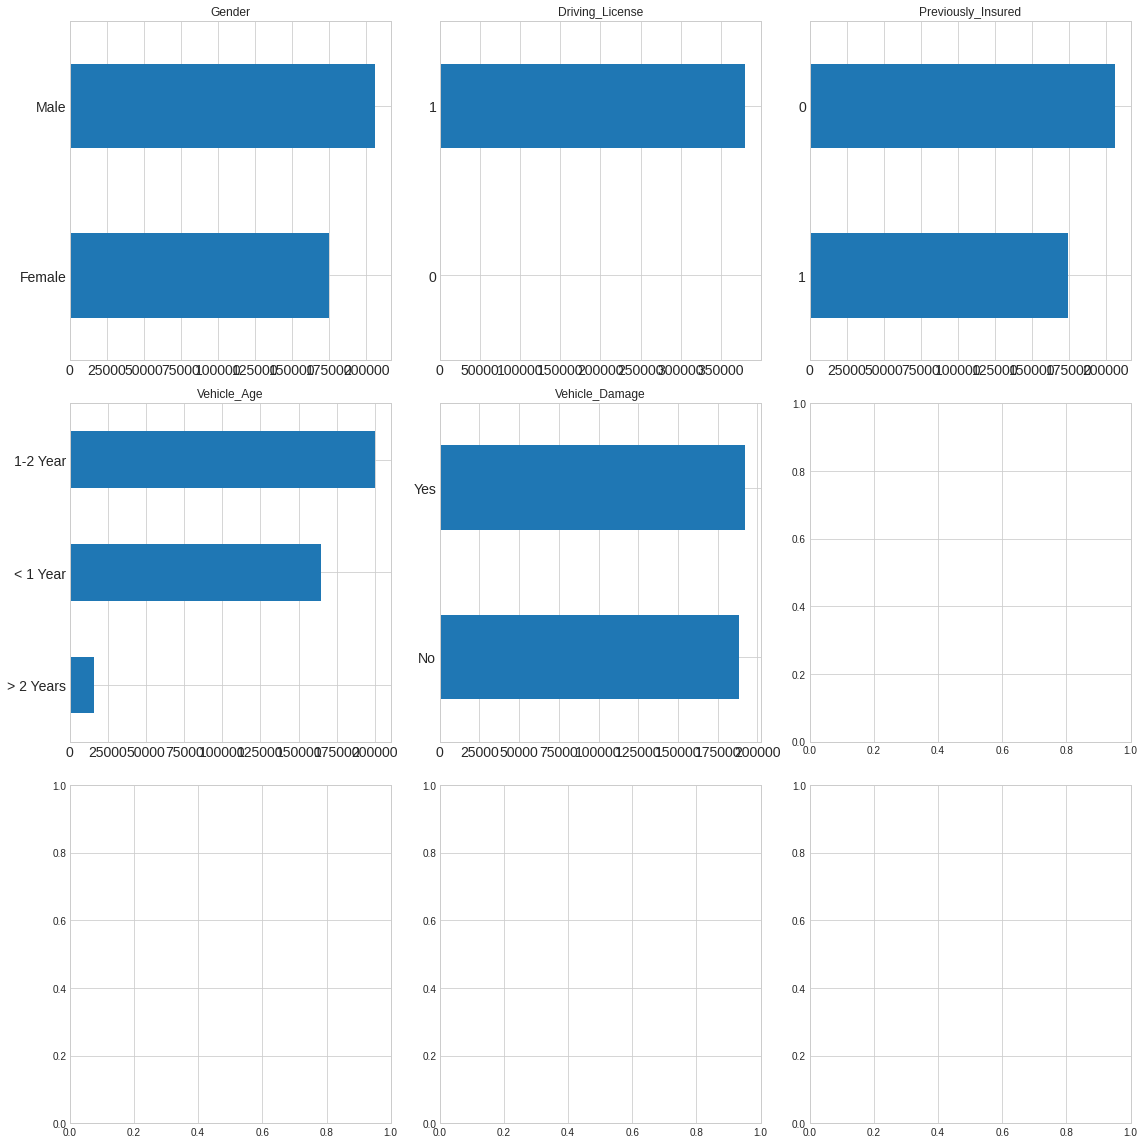

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

## Bivariate Analysis Relationships with Target

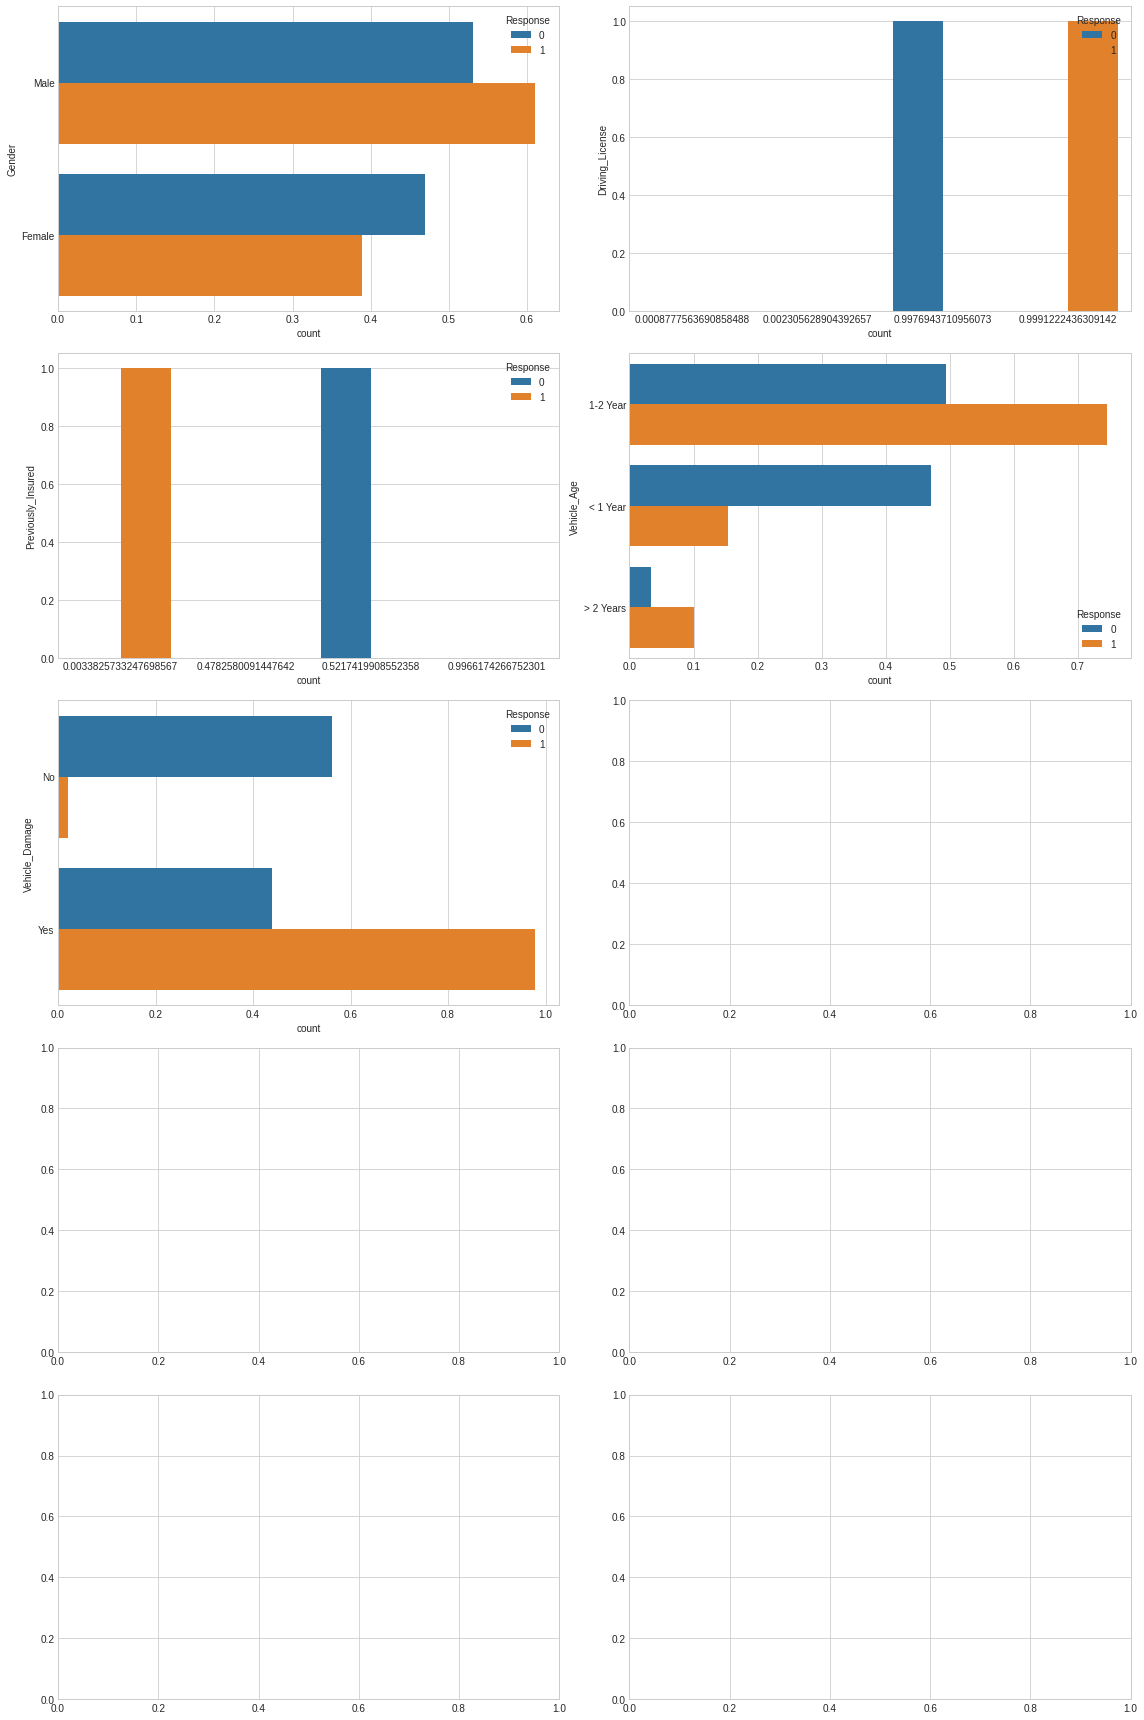

In [23]:
fig, axes = plt.subplots(5, 2, figsize=(16, 24))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    fltr = train[TARGET_COL] == 0
    vc_a = train[fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_b = train[~fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_a[TARGET_COL] = 0
    vc_b[TARGET_COL] = 1

    df = pd.concat([vc_a, vc_b]).reset_index(drop = True)

    _ = sns.barplot(y = c, x = 'count', data =df , hue=TARGET_COL, ax=axes[i])
    
_ = plt.tight_layout()

In [24]:
pd.crosstab(train[TARGET_COL],train['Driving_License'])

Driving_License,0,1
Response,,
0,771,333628
1,41,46669


In [25]:
pd.crosstab(train[TARGET_COL],train['Previously_Insured'])

Previously_Insured,0,1
Response,,
0,159929,174470
1,46552,158


### From the above chart, we can conclude few hypothesis that we have raised during the start


Are Male customers more interseted in opting for the to Vehicle Insurance compared to female customers ?
> Yes the Male customers more interseted in opting 

Customers holding driving license are likely to entertain the request for Vehicle Insurance or not?
>  771 customers neither have a driving license and not-interested in to get vehicle insurance for their vehicle hence people with driving license are more likely to opt

Customer with previous insurance are interested in opting?
>  previously not insured customers are highly interested to get vehicle insurance and at the same time Previously insured customers are not interested to get vehicle insurance.

Are the customers with less age of vehicle is not more interested in subscribing?
> from the above chart, less than 1 year old vehicle owners are less likely get insurance for their vehicle.1 to 2 years old Vehicle customers are highly interested to get insurance for their vehicle. If the vehicle is getting old , the customer is less likely to renew/get insurance for their vehicle.

Customer with damaged vehicles will opt or not? 
> Yes, damaged vehicle owners are very likely to get insurance for their vehicles.

# Univariate Analysis for num_cols - BOX Plots
### Let us now infer something from Numerical features as well

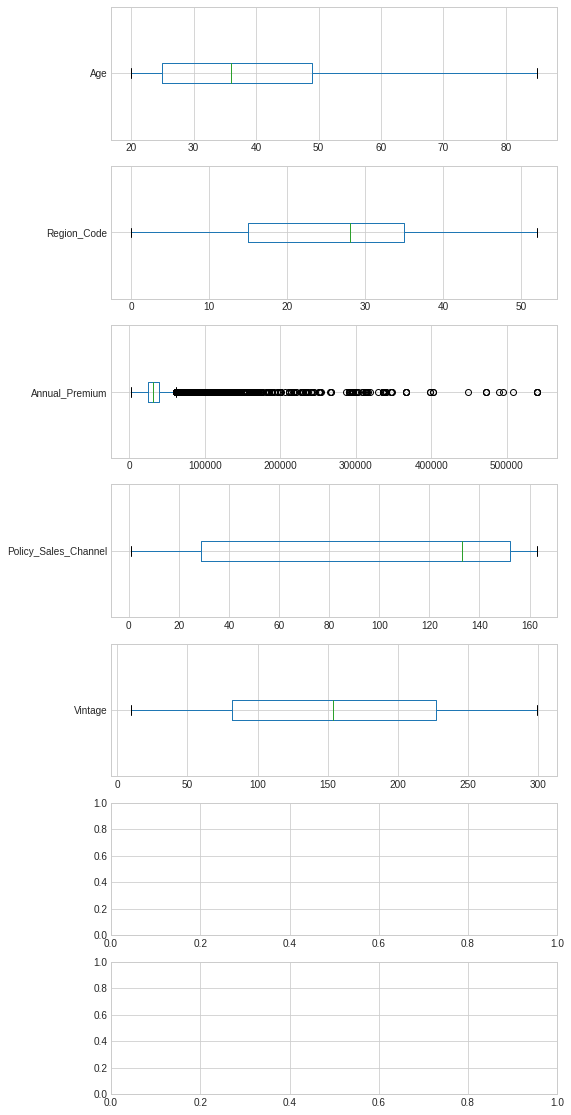

In [26]:
fig, axes = plt.subplots(7, 1, figsize=(8, 20))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)


From Above box plot we can see that annual premium have some outliers which is acceptable

## Bivariate Analysis - Horizontal BarPlots
* For each numerical Variable. We will plot the median of the numerical variable for:
* When Responce == 0 
* when Responce == 1
* We are choosing median since median is not affected by outliers, and our data has a lot of outliers

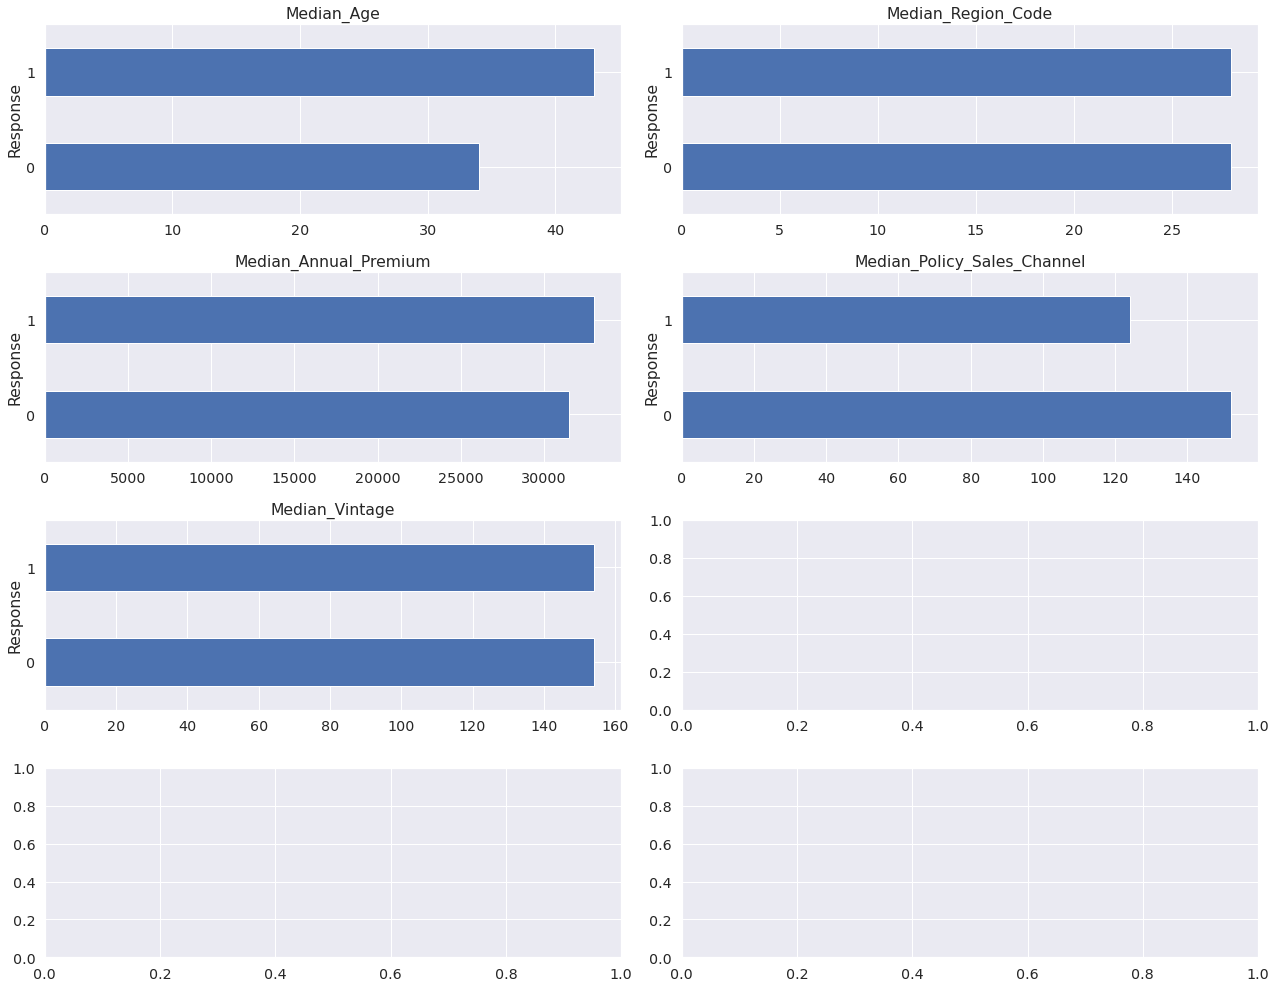

In [27]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = train.groupby(TARGET_COL)[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])
plt.tight_layout()

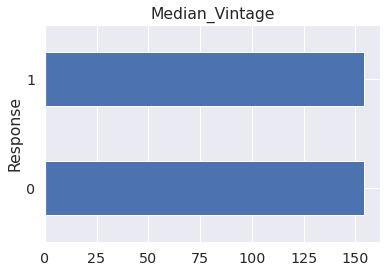

In [28]:
_ = train.groupby(TARGET_COL)['Vintage'].median().plot(kind = 'barh', title=f'Median_Vintage')

chart explains that the interested and non-interested customers of vehicle insurance and its age distribution mean to have a small difference. 

In [29]:
_ = train.groupby('Policy_Sales_Channel')[TARGET_COL].value_counts()
_

Policy_Sales_Channel  Response
1.0                   0            1039
                      1              35
2.0                   0               3
                      1               1
3.0                   0             364
                                  ...  
159.0                 1               1
160.0                 0           21304
                      1             475
163.0                 0            2013
                      1             880
Name: Response, Length: 274, dtype: int64

From above inference customers contacted via the channel 28 are highly interested to get insurance for their vehicle.

## Bivariate Analysis - Correlation Heatmaps

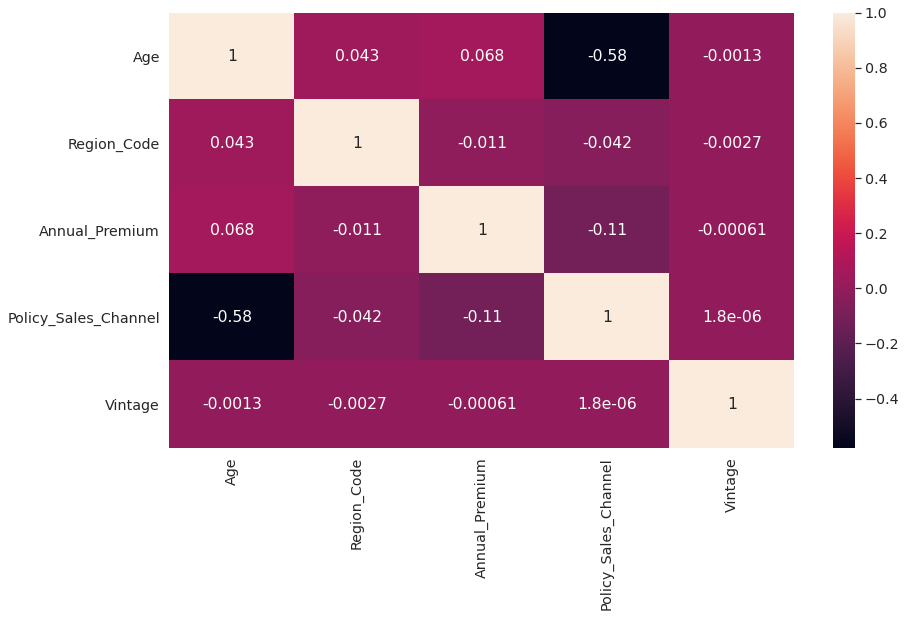

In [30]:
plt.figure(figsize=(14, 8))
_ = sns.heatmap(train[num_cols].corr(), annot=True)

From the above heat map we can see that the Age and Policy_Sales_Channel has negative correlation 

From all the above points, We observed few informations from the given dataset, They are,
* Response is Biased towards one class
* female customers are less interested to get insurance for their vehicles.
* Age distribution mean of interested and non-interested customers of vehicle insurance have only a small difference
* people with driving license are more likely to opt
* previously not insured customers are highly interested to get vehicle insurance and at the same time Previously insured customers are not interested to get vehicle insurance.
* From the above chart, less than 1 year old vehicle owners are less likely get insurance for their vehicle.1 to 2 years old Vehicle customers are highly interested to get insurance for their vehicle. If the vehicle is getting old , the customer is less likely to renew/get insurance for their vehicle.
* Damaged vehicle owners are very likely to get insurance for their vehicles.
* From above inference customers contacted via the channel 28 are highly interested to get insurance for their vehicle.

## Basic normalization, ohe and label encoding

In [31]:
def combine_df(train,test):
  train['is_train'] = 1
  test['is_train'] = 0
  return pd.concat([train,test],axis=0)

In [32]:
combined = combine_df(train,test)

In [33]:
combined['Vehicle_Age'].value_counts()

1-2 Year     267015
< 1 Year     219805
> 2 Years     21326
Name: Vehicle_Age, dtype: int64

In [34]:

vehicle_age = {"< 1 Year": 1,
               "1-2 Year": 2,
               "> 2 Years":3}
vehicle_damage = {"Yes":1,"No":0}

combined['Vehicle_Age'] = combined['Vehicle_Age'].map(vehicle_age)
combined['Vehicle_Damage'] = combined['Vehicle_Damage'].map(vehicle_damage)

In [35]:
combined['Gender'].value_counts()
combined['Gender']=combined['Gender'].replace({'Male':1,'Female':0})

In [36]:
train1 = combined[combined['is_train']==1]

test1 = combined[combined['is_train']==0]

Creating a Baseline model with very basic Preprocessed Data

In [37]:
test1 = test1.drop(['Response','is_train'],axis=1)

In [38]:
train1 = train1.drop(['is_train'],axis=1)

In [39]:
def split(df):
  '''
  Splitting the validation data set
  '''
  train_X, test_X, train_y, test_y  = train_test_split(df.drop(['Response','id'], axis=1), \
                                                  df['Response'].astype('int'),
                                                    test_size=0.20,shuffle=True,
                                                    random_state=0,
                                                    stratify=df['Response'])
  return train_X, test_X, train_y, test_y

In [40]:
train_X, test_X, train_y, test_y = split(train1)

In [41]:
from sklearn.preprocessing import StandardScaler
stnd_x =StandardScaler()
train_X = stnd_x.fit_transform(train_X)
test_X  =  stnd_x.fit_transform(test_X)




In [42]:
def run_model_validate(model, train_X, train_y, test_X, test_y):
    model.fit(train_X, train_y)
    pred_train = model.predict(train_X)
    pred_test = model.predict(test_X)
    return model, roc_auc_score(train_y, pred_train), roc_auc_score(test_y, pred_test)

In [43]:
result = []
#model = [Lasso(alpha=0.025),LassoLars(alpha=0.025),Ridge(alpha=0.025),LinearRegression]
model = [ LogisticRegression() ]
for model in model:
    print ("Model Name:",model)
    model_name,Train_Roc, Test_Roc = run_model_validate(model, train_X, train_y, test_X, test_y)
    result.append([model_name, Train_Roc, Test_Roc])

Model Name: LogisticRegression()


In [44]:
pd.DataFrame(result, columns = ["model_name", "Train_RMSE", "Test_RMSE"]) 

,model_name,Train_RMSE,Test_RMSE
0,LogisticRegression(),0.500887,0.50084


### Without any feature engineering we can obtain the ROC_AUC score of 0.50

# Feature Engineering

In [45]:
combined['Vintage'] = combined['Vintage']/365

In [46]:
#Analysis show that people in Age Group 30-60 have higher response rate so creating a separate feature
combined['Age_Group'] = np.where((combined['Age']<30) & (combined['Age'] > 60),0,1)

In [47]:
combined['IsPreviouslyInsuredandVehicleDamaged'] = np.where((combined['Previously_Insured']==0) & (combined['Vehicle_Damage']==1),1,0)
combined['IsVehicleDamagedandDrivingLicense'] = np.where((combined['Vehicle_Damage']==1) & (combined['Driving_License']==1),1,0)

In [48]:
combined['TotalAmountPaidTillDate'] = combined['Annual_Premium']*combined['Vintage']
combined['PremiumperRegion'] = combined.groupby('Region_Code')['Annual_Premium'].transform('mean')
combined['PremiumperPolicy_Sales_Channel'] = combined.groupby('Policy_Sales_Channel')['Annual_Premium'].transform('mean')

In [49]:
combined['AvgVehicleAgePerRegion'] = combined.groupby('Policy_Sales_Channel')['Annual_Premium'].transform('mean')
combined['AvgCustomerAgeRegionWise'] = combined.groupby('Region_Code')['Age'].transform('mean')
combined['AvgCustomerAgeSaleChannelWise'] = combined.groupby('Policy_Sales_Channel')['Age'].transform('mean')
combined['SaleChannelsPerRegion'] = combined.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique')
combined['RegionwisePreviouslyInsured'] = combined.groupby('Region_Code')['Previously_Insured'].transform('count')
combined['RegionwiseVintage'] = combined.groupby('Region_Code')['Vintage'].transform('mean').astype('int')
combined['SaleChannelwiseVintage'] = combined.groupby('Policy_Sales_Channel')['Vintage'].transform('mean').astype('int')

In [50]:
combined.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'is_train', 'Age_Group',
       'IsPreviouslyInsuredandVehicleDamaged',
       'IsVehicleDamagedandDrivingLicense', 'TotalAmountPaidTillDate',
       'PremiumperRegion', 'PremiumperPolicy_Sales_Channel',
       'AvgVehicleAgePerRegion', 'AvgCustomerAgeRegionWise',
       'AvgCustomerAgeSaleChannelWise', 'SaleChannelsPerRegion',
       'RegionwisePreviouslyInsured', 'RegionwiseVintage',
       'SaleChannelwiseVintage'],
      dtype='object')

In [51]:
combined['AvgRegionGenderWisePremium'] = combined.groupby(['Region_Code','Gender'])['Annual_Premium'].transform('mean')
combined['NoPeoplePrevInsuredRegionGenderWise'] = combined.groupby(['Region_Code','Gender'])['Previously_Insured'].transform('count')
combined['NoPeoplePrevInsuredSalesChannelGenderWise'] = combined.groupby(['Policy_Sales_Channel','Gender'])['Previously_Insured'].transform('count')
combined['NoPeoplePrevInsuredSalesChannelRegionWise'] = combined.groupby(['Region_Code','Policy_Sales_Channel'])['Previously_Insured'].transform('count')
combined['AvgCustomerDurationRegionGenderWise'] = combined.groupby(['Region_Code','Gender'])['Vintage'].transform('mean')

Changing Dtype from float to int to improve performance

In [52]:
combined['Region_Code']=combined['Region_Code'].astype(int)
combined['Policy_Sales_Channel']=combined['Policy_Sales_Channel'].astype(int)

In [53]:

# categorical column 
cat_col=['Gender','Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']

In [54]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508146 entries, 0 to 127036
Data columns (total 31 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   id                                         508146 non-null  int64  
 1   Gender                                     508146 non-null  int64  
 2   Age                                        508146 non-null  int64  
 3   Driving_License                            508146 non-null  int64  
 4   Region_Code                                508146 non-null  int64  
 5   Previously_Insured                         508146 non-null  int64  
 6   Vehicle_Age                                508146 non-null  int64  
 7   Vehicle_Damage                             508146 non-null  int64  
 8   Annual_Premium                             508146 non-null  float64
 9   Policy_Sales_Channel                       508146 non-null  int64  
 10  Vintage 

In [55]:
train = combined[combined['Response'].isnull()!= True]
test = combined[combined['Response'].isnull()== True]

In [56]:
test.drop(['Response'],axis=1,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# MODELLING

In [57]:
X = train.drop(["Response"], axis=1)
Y = train["Response"]

In [58]:
X.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'is_train', 'Age_Group',
       'IsPreviouslyInsuredandVehicleDamaged',
       'IsVehicleDamagedandDrivingLicense', 'TotalAmountPaidTillDate',
       'PremiumperRegion', 'PremiumperPolicy_Sales_Channel',
       'AvgVehicleAgePerRegion', 'AvgCustomerAgeRegionWise',
       'AvgCustomerAgeSaleChannelWise', 'SaleChannelsPerRegion',
       'RegionwisePreviouslyInsured', 'RegionwiseVintage',
       'SaleChannelwiseVintage', 'AvgRegionGenderWisePremium',
       'NoPeoplePrevInsuredRegionGenderWise',
       'NoPeoplePrevInsuredSalesChannelGenderWise',
       'NoPeoplePrevInsuredSalesChannelRegionWise',
       'AvgCustomerDurationRegionGenderWise'],
      dtype='object')

In [59]:
def feature_importance(model, X_train):

    fI = model.feature_importances_
    
    print(fI)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, fI)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 228665 rows of holdout = 152444
[0]	validation_0-auc:0.72491	validation_0-logloss:0.66962
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85712	validation_0-logloss:0.27120
[200]	validation_0-auc:0.85816	validation_0-logloss:0.26489
[300]	validation_0-auc:0.85830	validation_0-logloss:0.26431
Stopping. Best iteration:
[349]	validation_0-auc:0.85835	validation_0-logloss:0.26422

XGB Val OF AUC= 0.8583518230583136
####################################################################################################
[0.00100555 0.00116499 0.00805533 0.00191157 0.00122255 0.21026543
 0.00513874 0.14987282 0.00121345 0.00283921 0.00088203 0.
 0.         0.41064838 0.16770397 0.00101297 0.00136833 0.00212696
 0.00268424 0.0

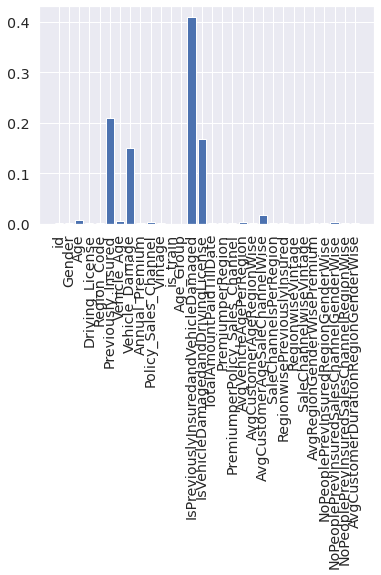

Fold 1
 rows of train = 228665 rows of holdout = 152444
[0]	validation_0-auc:0.72729	validation_0-logloss:0.66963
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85855	validation_0-logloss:0.27084
[200]	validation_0-auc:0.85955	validation_0-logloss:0.26440
[300]	validation_0-auc:0.85954	validation_0-logloss:0.26387
[400]	validation_0-auc:0.85928	validation_0-logloss:0.26387
Stopping. Best iteration:
[355]	validation_0-auc:0.85943	validation_0-logloss:0.26382

XGB Val OF AUC= 0.8594310315612391
####################################################################################################
Fold 2
 rows of train = 228665 rows of holdout = 152444
[0]	validation_0-auc:0.72520	validation_0-logloss:0.66963
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't im

In [60]:
from tqdm.notebook import tqdm ,tnrange
pred_test = np.zeros(shape=(len(test),))

scores = []

avg_loss = []

test_size = 0.4

X_train_cv,y_train_cv = X.copy(), Y.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = XGBClassifier(n_estimators=1000,
                                max_depth=6,
                                learning_rate=0.04,
                                subsample=0.9,
                                colsample_bytree=0.35,
                                objective = 'binary:logistic',
                                random_state = 1
                               )        


        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['auc','logloss'],
                    early_stopping_rounds=50)
        
        pred_train = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        pred_test +=clf.predict_proba(test)[:,1]

        roc = roc_auc_score(y_train_cv.iloc[idxV],pred_train)

        scores.append(roc)
        
        avg_loss.append(clf.best_score)

        print ('XGB Val OF AUC=',roc)

        print('#'*100)

        if i==0:
            
            feature_importance(clf,X_train_cv)
            


We can see there is a massive improvement in the value of ROC_AUC score value  # 0.8597330023933047

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [62]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000]}


In [63]:
sample_x_train = X.sample(frac=0.3, replace=True, random_state=1)
sample_y_train = Y.sample(frac=0.3, replace=True, random_state=1)

In [64]:
print(sample_x_train.shape)
print(sample_y_train.shape)


(114333, 30)
(114333,)


In [65]:
rf_random.best_params_

NameError: name 'rf_random' is not defined

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 228665 rows of holdout = 152444
RF Val OF AUC= 0.8554734077429426
####################################################################################################
[1.35460129e-02 9.85339511e-04 3.55336612e-02 2.82187073e-04
 5.40583353e-03 1.54406067e-02 1.77199663e-03 2.45016059e-06
 9.00968677e-03 5.71301943e-03 9.42803583e-03 0.00000000e+00
 0.00000000e+00 7.96911698e-01 6.74355010e-04 1.02086799e-02
 2.64284452e-03 2.89317834e-03 2.72960073e-03 4.65478900e-03
 5.57965489e-02 3.30061462e-03 1.46621136e-03 0.00000000e+00
 0.00000000e+00 4.25788336e-03 2.70191799e-03 3.60688109e-03
 6.66906546e-03 4.36690241e-03]


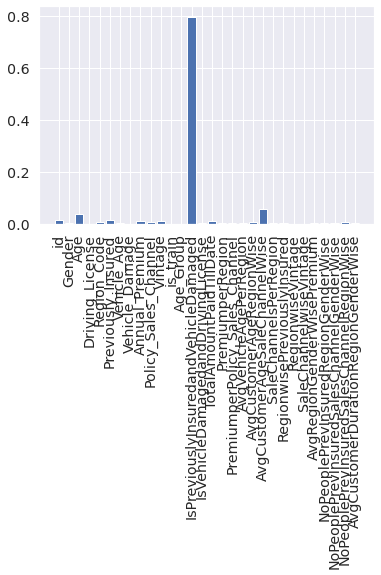

Fold 1
 rows of train = 228665 rows of holdout = 152444
RF Val OF AUC= 0.8560008242570467
####################################################################################################



In [66]:
from tqdm.notebook import tqdm ,tnrange
pred_test = np.zeros(shape=(len(test),))

scores = []

avg_loss = []

test_size = 0.4

X_train_cv,y_train_cv = X.copy(), Y.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=2, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = RandomForestClassifier(random_state=0, max_depth=10, 
                                            class_weight={0:0.12, 1:0.88}, 
                                            n_estimators=500, max_features=None, n_jobs=4)        


        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT])
        
        pred_train = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        pred_test +=clf.predict_proba(test)[:,1]

        roc = roc_auc_score(y_train_cv.iloc[idxV],pred_train)

        scores.append(roc)
        
        #avg_loss.append(clf.best_score)

        print ('RF Val OF AUC=',roc)

        print('#'*100)

        if i==0:
            
            feature_importance(clf,X_train_cv)
            


we can see that the ROC_AUC(0.8560008242570467) value of RF is bit low than XGB # 

#Hyperparameter tuning of RandomForest Classifier using Bayesian optimization

In [67]:
#Hyperparameter tuning of RandomForest Classifiers using Bayesian optimization

def rfc_cv(n_estimators, min_samples_split, max_features, data, targets):
    estimator = RandomForestClassifier(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=2,
        n_jobs = -1
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring='roc_auc', cv=5)
    return cval.mean()

In [68]:
def optimize_rfc(data, targets):
    def rfc_crossval(n_estimators, min_samples_split, max_features):
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (100, 450),
            "min_samples_split": (2, 25),
            "max_features": (0.1, 0.999),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=10)

    print("Final result:", optimizer.max)

In [69]:
print(("--- Optimizing Random Forest ---"))
optimize_rfc(sample_x_train,sample_y_train)

--- Optimizing Random Forest ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.884    |  0.2722   |  16.31    |  253.2    |
|  2        |  0.8831   |  0.806    |  19.94    |  195.4    |
|  3        |  0.8827   |  0.3485   |  20.44    |  435.3    |
|  4        |  0.888    |  0.8875   |  10.23    |  275.3    |
|  5        |  0.884    |  0.7144   |  18.39    |  229.6    |
|  6        |  0.8852   |  0.6045   |  13.57    |  104.8    |
|  7        |  0.882    |  0.7948   |  22.3     |  227.7    |
|  8        |  0.8926   |  0.6532   |  3.734    |  229.1    |
|  9        |  0.8845   |  0.9389   |  16.98    |  239.0    |
|  10       |  0.8891   |  0.8091   |  9.287    |  298.8    |
|  11       |  0.8897   |  0.1087   |  2.0      |  221.0    |
|  12       |  0.8927   |  0.2732   |  2.27     |  237.1    |
|  13       |  0.8815   |  0.4539   |  24.97    |  320.8    |
|  14       |  0.8932   |  0.7603   |

In [70]:
rfc = RandomForestClassifier(n_estimators = int(423.1587542796294),
                           min_samples_split=int(2.0238217007431984),
                           max_features = 0.49606210177152577,
                           n_jobs = -1, 
                           random_state = 2)

In [71]:
#Hyperparameter tuning of XGBoostClassification using Bayesian optimization

def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, targets):
    estimator = XGBClassifier(
        n_estimators=n_estimators,
        max_depth = max_depth,
        gamma = gamma,
        min_child_weight=min_child_weight,
        subsample = subsample,
        random_state = 2,
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring='roc_auc', cv=3)
    return cval.mean()

In [72]:
def optimize_xgb(data, targets):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth = int(max_depth),
            gamma = gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "n_estimators": (200, 500),
            "max_depth": (6,15),
            "gamma": (0,10),
            "min_child_weight": (0,10),
            "subsample": (0.8,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=5, init_points=20)

    print("Final result:", optimizer.max)

In [73]:
print(("--- Optimizing XGBoost ---"))
optimize_xgb(sample_x_train,sample_y_train)

--- Optimizing XGBoost ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.867    |  1.915    |  11.6     |  4.377    |  435.6    |  0.956    |
|  2        |  0.8627   |  2.726    |  8.488    |  8.019    |  487.4    |  0.9752   |
|  3        |  0.8626   |  3.578    |  10.51    |  6.835    |  413.8    |  0.8741   |
|  4        |  0.8653   |  5.612    |  10.53    |  0.1377   |  431.8    |  0.9765   |
|  5        |  0.8681   |  3.649    |  11.54    |  0.7538   |  310.6    |  0.9866   |
|  6        |  0.8587   |  6.514    |  9.575    |  7.887    |  295.1    |  0.9136   |
|  7        |  0.8576   |  8.691    |  9.926    |  8.021    |  243.1    |  0.9409   |
|  8        |  0.8582   |  7.046    |  7.969    |  9.249    |  332.6    |  0.9819   |
|  9        |  0.87     |  0.5981   |  7.659    |  0.4736   |  402.5    |  0.9189   |
|  10       |  0.8588   |  

In [74]:
xgb = XGBClassifier(
        n_estimators=int(399.8838318438175),
        max_depth = int(13.787765400993287),
        gamma = 0.10267293137504852,
        min_child_weight=0.32614748423714035,
        subsample = 0.8184588028819323,
        random_state = 2,
    )

In [75]:
#Hyperparameter tuning of XGBoost RandomForest Classifier using Bayesian optimization

def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, targets):
    estimator = XGBRFClassifier(
        n_estimators=n_estimators,
        max_depth = max_depth,
        gamma = gamma,
        min_child_weight=min_child_weight,
        subsample = subsample,
        random_state = 2,
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring='roc_auc', cv=3)
    return cval.mean()

In [76]:
def optimize_xgb(data, targets):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth = int(max_depth),
            gamma = gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "n_estimators": (200, 500),
            "max_depth": (6,15),
            "gamma": (0,10),
            "min_child_weight": (0,10),
            "subsample": (0.8,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=5, init_points=20)

    print("Final result:", optimizer.max)

In [77]:
print(("--- Optimizing XGBoost RandomForest ---"))
optimize_xgb(sample_x_train,sample_y_train)

--- Optimizing XGBoost RandomForest ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.8561   |  1.915    |  11.6     |  4.377    |  435.6    |  0.956    |
|  2        |  0.8534   |  2.726    |  8.488    |  8.019    |  487.4    |  0.9752   |
|  3        |  0.8554   |  3.578    |  10.51    |  6.835    |  413.8    |  0.8741   |
|  4        |  0.8547   |  5.612    |  10.53    |  0.1377   |  431.8    |  0.9765   |
|  5        |  0.856    |  3.649    |  11.54    |  0.7538   |  310.6    |  0.9866   |
|  6        |  0.8537   |  6.514    |  9.575    |  7.887    |  295.1    |  0.9136   |
|  7        |  0.853    |  8.691    |  9.926    |  8.021    |  243.1    |  0.9409   |
|  8        |  0.852    |  7.046    |  7.969    |  9.249    |  332.6    |  0.9819   |
|  9        |  0.8529   |  0.5981   |  7.659    |  0.4736   |  402.5    |  0.9189   |
|  10       | 

In [78]:
xgbrf = XGBRFClassifier(
        n_estimators=int(383.4270643276214),
        max_depth = int(15.0),
        gamma = 0.0,
        min_child_weight=1.6542457263238466,
        subsample = 0.8,
        random_state = 2,
    )

In [79]:
estimators = [('rfc' , rfc),('xgb',xgb),('xgbrf',xgbrf)]
#model = StackingClassifier(estimators=estimators)

from tqdm.notebook import tqdm ,tnrange
pred_test = np.zeros(shape=(len(test),))

scores = []

avg_loss = []

test_size = 0.4

X_train_cv,y_train_cv = X.copy(), Y.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=2, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = StackingClassifier(estimators=estimators)        


        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT])
        
        pred_train = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        pred_test +=clf.predict_proba(test)[:,1]

        roc = roc_auc_score(y_train_cv.iloc[idxV],pred_train)

        scores.append(roc)
        
        #avg_loss.append(clf.best_score)

        print ('StackingClassifier Val OF AUC=',roc)

        print('#'*100)

       

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 228665 rows of holdout = 152444
StackingClassifier Val OF AUC= 0.8523433710744757
####################################################################################################
Fold 1
 rows of train = 228665 rows of holdout = 152444
StackingClassifier Val OF AUC= 0.8521960006559611
####################################################################################################



In [80]:
ss['Response'] = pred_test

In [81]:
ss.to_csv("Stackingclassifier_Submission.csv", index = False)

Additional Work with CatBoostClassifier

In [82]:
from catboost import CatBoostClassifier
oof_pred               = np.zeros((len(train),))
y_pred_final           = np.zeros((len(test),))
num_models             = 3

n_splits               = 5
error                  = []

kf=StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=294)
    
for i,(train_idx,val_idx) in enumerate(kf.split(X,Y)):    
    
    wghts                     = [0]*num_models
    test_roc_score            = []
    
    
    X_train, y_train = X.iloc[train_idx,:], Y.iloc[train_idx]

    X_val, y_val = X.iloc[val_idx, :], Y.iloc[val_idx]
    

    print('\nFold: {}\n'.format(i+1))

    model1 = CatBoostClassifier(learning_rate = 0.03,random_state=42,scale_pos_weight=7, custom_metric=['AUC'])
    model1.fit(X_train,y_train,cat_features=cat_col,eval_set=(X_val, y_val),early_stopping_rounds=30,verbose=100)
    testpred1 = model1.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred1))
    print("Test ROC AUC for model 1: %.4f"%(roc_auc_score(y_val, testpred1)))
    
    model2 = CatBoostClassifier(learning_rate = 0.04,random_state=42,scale_pos_weight=7, custom_metric=['AUC'])
    model2.fit(X_train,y_train,cat_features=cat_col,eval_set=(X_val, y_val),early_stopping_rounds=40,verbose=100)
    testpred2 = model2.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred2))
    print("Test ROC AUC for model 2: %.4f"%(roc_auc_score(y_val, testpred2)))
    
    model3 = CatBoostClassifier(learning_rate = 0.05,random_state=42,scale_pos_weight=7, custom_metric=['AUC'])
    model3.fit(X_train,y_train,cat_features=cat_col,eval_set=(X_val, y_val),early_stopping_rounds=20,verbose=100)
    testpred3 = model3.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred3))
    print("Test ROC AUC for model 3: %.4f"%(roc_auc_score(y_val, testpred3)))
    
    wghts              = np.exp(-1000*np.array(test_roc_score/sum(test_roc_score)))
    wghts              = wghts/sum(wghts)
    
    val_pred           = wghts[0]*testpred1+wghts[1]*testpred2 +wghts[2]*testpred3
    print('validation roc_auc_score fold-',i+1,': ',roc_auc_score(y_val, val_pred))
    
    oof_pred[val_idx]  = val_pred
    y_pred_final += (wghts[0]*model1.predict_proba(test)[:,1]+wghts[1]*model2.predict_proba(test)[:,1]+wghts[2]*model3.predict_proba(test)[:,1])/(n_splits)
    
    print('\n')
    
print('OOF ROC_AUC_Score:- ',(roc_auc_score(Y,oof_pred)))


Fold: 1

0:	learn: 0.6739625	test: 0.6739727	best: 0.6739727 (0)	total: 303ms	remaining: 5m 2s
100:	learn: 0.4240648	test: 0.4255860	best: 0.4255860 (100)	total: 21.4s	remaining: 3m 10s
200:	learn: 0.4199355	test: 0.4223885	best: 0.4223885 (200)	total: 43.1s	remaining: 2m 51s
300:	learn: 0.4179895	test: 0.4211883	best: 0.4211883 (300)	total: 1m 3s	remaining: 2m 26s
400:	learn: 0.4166173	test: 0.4206433	best: 0.4206433 (400)	total: 1m 23s	remaining: 2m 5s
500:	learn: 0.4148619	test: 0.4201654	best: 0.4201654 (500)	total: 1m 46s	remaining: 1m 45s
600:	learn: 0.4131971	test: 0.4199980	best: 0.4199912 (594)	total: 2m 7s	remaining: 1m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4199912074
bestIteration = 594

Shrink model to first 595 iterations.
Test ROC AUC for model 1: 0.8604
0:	learn: 0.6677952	test: 0.6678097	best: 0.6678097 (0)	total: 238ms	remaining: 3m 57s
100:	learn: 0.4224602	test: 0.4242563	best: 0.4242563 (100)	total: 21.5s	remaining: 3m 11s
200:	lea

In [83]:
ss['Response']=y_pred_final
ss.to_csv("cat_Submission.csv", index = False)
